## $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\textbf{4. The delta gamma approximation:}$



In [130]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as op

In [131]:
m=int(1e5)
T0=120
Y=252
T=10
mu=0
sigma = 0.3
S0,K=100,100

X=np.random.normal(size=(m,T))              
logIncr=-sigma*sigma/(2*Y)+sigma*X/np.sqrt(Y)                 # We use the incremental method to simulate Brownian Motion
logS=np.cumsum(logIncr,axis=1)
S=S0*np.exp(logS)

### 4.1 Calculation of parameters theta delta and gamma :

In [132]:
def d1(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) + sig*np.sqrt(to)/2
def d2(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) - sig*np.sqrt(to)/2

def callPrice(S,t,K,sigma,T):
    return S*sps.norm.cdf(d1(T-t,S,K,sigma))-K*sps.norm.cdf(d2(T-t,S,K,sigma))
def putPrice(S,t,K,sigma,T):
    return K*sps.norm.cdf(d1(T-t,K,S,sigma))-S*sps.norm.cdf(d2(T-t,K,S,sigma))

#for a call:
def thetaC(S0,K,sigma,T):
    return -S0*sigma*np.exp(-(d1((T0-T)/Y,S0,K,sigma)**2)/2)/(2*np.sqrt(np.pi*2*(T0-T)/Y))
def deltaC(S0,K,sigma,T):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))
def gammaC(S0,K,sigma,T):
    return np.exp(-(d1((T0-T)/Y,S0,K,sigma)**2)/2)/(sigma*S0*np.sqrt(np.pi*2*(T0-T)/Y))

#for a put:
def thetaP(S0,K,sigma,T):
    return -S0*sigma*np.exp(-(d1((T0-T)/Y,S0,K,sigma)**2)/2)/(2*np.sqrt(np.pi*2*(T0-T)/Y))
def deltaP(S0,K,sigma,T):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))-1
def gammaP(S0,K,sigma,T):
    return np.exp(-(d1((T0-T)/Y,S0,K,sigma)**2)/2)/(sigma*S0*np.sqrt(np.pi*2*(T0-T)/Y))


print("parameter values are for this call option are:")
print("theta_Call : "+repr(thetaC(S0,K,sigma,T)))
print("delta_Call : "+repr(deltaC(S0,K,sigma,T)))
print("gamma_Call : "+repr(gammaC(S0,K,sigma,T))+"\n")
print("parameter values are for this put option are:")
print("theta_Put : "+repr(thetaP(S0,K,sigma,T)))
print("delta_Put : "+repr(deltaP(S0,K,sigma,T)))
print("gamma_Put : "+repr(gammaP(S0,K,sigma,T)))

parameter values are for this call option are:
theta_Call : -9.0130661096696
delta_Call : 0.5394718029141008
gamma_Call : 0.020029035799265776

parameter values are for this put option are:
theta_Put : -9.0130661096696
delta_Put : -0.4605281970858992
gamma_Put : 0.020029035799265776


### 4.2 Delta-gamma Loss function and VaR estimation :

 The variation of S over T period of time can be seen as a normal variable,
 
 more precisely : 
 
 $$ \Delta S \sim \mathcal N(0,\frac{T}{Y}*\sigma^2*S_{0}^2) $$

Text(0.5, 1.0, '$\\Delta $S distribution for one stock price')

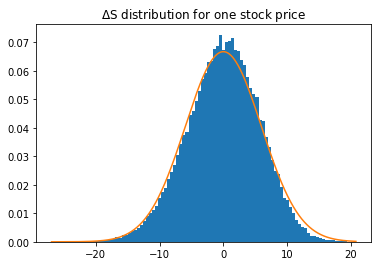

In [133]:
DS=S[:,0]-S[:,9]
x=np.linspace(min(DS),max(DS),m)
plt.hist(DS,density=True,bins=100)
plt.plot(x,sps.norm.pdf(x,0,S0*sigma*np.sqrt(T/Y)))
plt.title('$\Delta $S distribution for one stock price')

DG approximation Loss function :

In [134]:
#for a call:
def Loss_DGC(S,S0,K,sigma,T,N):
    SLoss=S0*sigma*np.sqrt(T/Y)*np.random.randn(N)
    return -(T/Y)*thetaC(S0,K,sigma,T)-deltaC(S0,K,sigma,T)*SLoss-(gammaC(S0,K,sigma,T)*SLoss**2)/2

#for a put:
def Loss_DGP(S,S0,K,sigma,T,N):
    SLoss=S0*sigma*np.sqrt(T/Y)*np.random.randn(N)
    return -T*thetaP(S0,K,sigma,T)/Y-deltaP(S0,K,sigma,T)*SLoss-(gammaP(S0,K,sigma,T)*SLoss**2)/2

In [135]:
alpha=1-1e-4
LossDGC=np.sort(Loss_DGC(S,S0,K,sigma,T,m))        
LossDGP=np.sort(Loss_DGP(S,S0,K,sigma,T,m))
VaRC=LossDGC[int(np.ceil(m*alpha))]
VaRP=LossDGP[int(np.ceil(m*alpha))]
print('VaR for the call option using delta-gamma approximation is : {} . '.format(VaRC))
print('VaR for the put option using delta-gamma approximation is : {} . '.format(VaRP))

VaR for the call option using delta-gamma approximation is : 7.382164136389545 . 
VaR for the put option using delta-gamma approximation is : 5.643112752214795 . 


### 4.3 VaR and Conditional VaR estimation using exponentional twisting:

Expected shortfall or conditional VaR is equals :  $$ \bar{\textbf{Q}}^{\textbf{X}}(\alpha)= \frac{\textbf{1}}{\textbf{1}-\alpha} \mathbb{E}\left (\textbf{X}\mathbb{1}_{\textbf{X}\ge\textbf{Q}^{\textbf{X}}(\alpha)}\right)$$

first of all we define :   $$x_{\alpha}:=\textbf{Q}^{\textbf{X}}(\alpha) ~~~~~~~~~~~~~~~~~~~~(Var~~value~for~\alpha)$$

and: $$f(\textbf{X}):=\textbf{X}\mathbb{1}_{\textbf{X}\ge x_{\alpha}}$$
and we have:    $$ \textbf{X}=Loss=-\Theta*\textbf{T}-\delta*\sqrt{T}*\sigma*S_{0}*\textbf{Z}-\frac{\gamma}{2}*T*\sigma^2*S_{0}^2*\textbf{Z}^{2}~~~~~with~~~~~~\textbf{Z}\sim \mathcal N(0,1)$$   
Or more simply : $$ \textbf{X}=a_{0}+\textbf{Q}~~~~~~~~~~~with~~~~~~~~ \textbf{Q}=b*\textbf{Z}+\lambda*\textbf{Z}^{2}$$
         
So we can estimate the mean quantity term using exponential twisting :
 
we have : $$\mathbb{E}\left [f(a_{0}+\textbf{Q}) \right]=\mathbb{E}_{\theta}\left [f(a_{0}+\textbf{Q'})*L(\textbf{Z'}) \right]~~~~~~~~ with~~~~~~~~\textbf{Z'}\sim \mathcal N \left ( \mu(\theta),B(\theta)\right)$$

with: $$ \mu(\theta)=\theta*B(\theta)*b~~~~~~~~~~~~~~~and~~~~~~~~~~~~~~~B(\theta)=\frac{1}{1-\lambda*\theta}$$

and the likelihood ratio (LR): $$L(\textbf{Z'}^{2})=\frac{exp(\frac{-1}{2}\textbf{Z'}^{2})}{\sqrt{B^{-1}}*exp(\frac{-(\textbf{Z'}-\mu)^2}{2B})}$$

Using the results of Glassermann & al. 2000's paper, we find that the value of $\theta$ minimizing the variance is :$$\theta_{x_{\alpha}}~~such~~as~~~~~[\Psi'(\theta)=x_{\alpha}-a_{0}~~with~~condition~~\lambda*\theta<\frac{1}{2}]$$


In [136]:
#setting parameters:
def a0(S0,K,sigma,T):
    return -T*thetaC(S0,K,sigma,T)/Y
def b_C(S0,K,sigma,T,hedged=False):
    if hedged:
        return 0
    return -S0*sigma*np.sqrt(T/Y)*deltaC(S0,K,sigma,T)
def b_P(S0,K,sigma,T,hedged=False):
    if hedged:
        return 0
    return -S0*sigma*np.sqrt(T/Y)*deltaP(S0,K,sigma,T)
def la_C(S0,K,sigma,T):
    return -gammaC(S0,K,sigma,T)*((S0*sigma)**2)*T/(2*Y)
def la_P(S0,K,sigma,T):
     return -gammaP(S0,K,sigma,T)*((S0*sigma)**2)*T/(2*Y)
def x_C(alpha,S0,K,sigma,T,hedged=False):
    if hedged:
        return HedgedVaRC-a0(S0,K,sigma,T)
    return VaRC-a0(S0,K,sigma,T)
def x_P(alpha,S0,K,sigma,T,hedged=False):
    if hedged:
        return HedgedVaRP-a0(S0,K,sigma,T)
    return VaRP-a0(S0,K,sigma,T)


#finding theta_x:
def theta_xC(alpha,S0,K,sigma,T,hedged=False):
    a=la_C(S0,K,sigma,T)*(b_C(S0,K,sigma,T,hedged))**2+4*x_C(alpha,S0,K,sigma,T,hedged)*la_C(S0,K,sigma,T)**2
    b=2*la_C(S0,K,sigma,T)**2-b_C(S0,K,sigma,T,hedged)**2-4*la_C(S0,K,sigma,T)*x_C(alpha,S0,K,sigma,T,hedged)
    c=x_C(alpha,S0,K,sigma,T,hedged)-la_C(S0,K,sigma,T)
    coeffs=[a,b,c]
    theta=np.roots(coeffs)
    for i in range(3):
        if theta[i]>0 and theta[i]*la_C(S0,K,sigma,T)<0.5:
            return theta[i]
    return 0
def theta_xP(alpha,S0,K,sigma,T,hedged=False):
    a=la_P(S0,K,sigma,T)*(b_P(S0,K,sigma,T,hedged))**2+4*x_P(alpha,S0,K,sigma,T,hedged)*la_P(S0,K,sigma,T)**2
    b=10*la_P(S0,K,sigma,T)**2-b_P(S0,K,sigma,T,hedged)**2-4*la_P(S0,K,sigma,T)*x_P(alpha,S0,K,sigma,T,hedged)
    c=x_P(alpha,S0,K,sigma,T,hedged)-9*la_P(S0,K,sigma,T)
    coeffs=[a,b,c,2]
    theta=np.roots(coeffs)
    for i in range(3):
        if theta[i]>0 and theta[i]*la_P(S0,K,sigma,T)<0.5:
            return theta[i]
    return 0
print("the value of theta minimizing variance for this call option is : "+repr(theta_xC(alpha,S0,K,sigma,T)))    
print("the value of theta minimizing variance for this put option is : "+repr(theta_xP(alpha,S0,K,sigma,T)))

the value of theta minimizing variance for this call option is : 7.3910711087375125
the value of theta minimizing variance for this put option is : 281.0025517528622


In [137]:
#setting mean and std values
def B_stdC(alpha,S0,K,sigma,T,hedged=False):
    return np.sqrt(1/(1-2*la_C(S0,K,sigma,T)*theta_xC(alpha,S0,K,sigma,T,hedged)))
def B_stdP(alpha,S0,K,sigma,T,hedged=False):
    return np.sqrt(1/(1-2*la_P(S0,K,sigma,T)*theta_xP(alpha,S0,K,sigma,T,hedged)))
def mu_C(alpha,S0,K,sigma,T,hedged=False):
    return theta_xC(alpha,S0,K,sigma,T,hedged)*(B_stdC(alpha,S0,K,sigma,T,hedged)**2)*b_C(S0,K,sigma,T,hedged)
def mu_P(alpha,S0,K,sigma,T,hedged=False):
    return theta_xP(alpha,S0,K,sigma,T,hedged)*(B_stdP(alpha,S0,K,sigma,T,hedged)**2)*b_P(S0,K,sigma,T,hedged)
def LR_C(alpha,S0,K,sigma,T,z,hedged=False):
    return sps.norm.pdf(z)/sps.norm.pdf(z,mu_C(alpha,S0,K,sigma,T,hedged),B_stdC(alpha,S0,K,sigma,T,hedged))
def LR_P(alpha,S0,K,sigma,T,z,hedged=False):
    return sps.norm.pdf(z)/sps.norm.pdf(z,mu_P(alpha,S0,K,sigma,T,hedged),B_stdP(alpha,S0,K,sigma,T,hedged))


In [138]:
#for a call:
print("The mean value of the IS new normal variable for this call option is : "+repr(mu_C(alpha,S0,K,sigma,T)))
print("The std value of the IS new normal variable for this call option is :"+repr(B_stdC(alpha,S0,K,sigma,T)))
#for a put:
print("\nThe mean value of the IS new normal variable for this put option is : "+repr(mu_P(alpha,S0,K,sigma,T)))
print("The std value of the IS new normal variable for this put option is :"+repr(B_stdP(alpha,S0,K,sigma,T)))


The mean value of the IS new normal variable for this call option is : -3.7901254574528846
The std value of the IS new normal variable for this call option is :0.3988211996318758

The mean value of the IS new normal variable for this put option is : 3.828423446590324
The std value of the IS new normal variable for this put option is :0.07035844727632952


In [139]:
#for a call:
def Q_C(alpha,S0,K,sigma,T,z,hedged=False):
    return b_C(S0,K,sigma,T,hedged)*z+la_C(S0,K,sigma,T)*(z**2)

#for a put:
def Q_P(alpha,S0,K,sigma,T,z,hedged=False):
    return b_P(S0,K,sigma,T,hedged)*z+la_P(S0,K,sigma,T)*(z**2)


#### 4.3.1 VaR calculation using importance sampling:

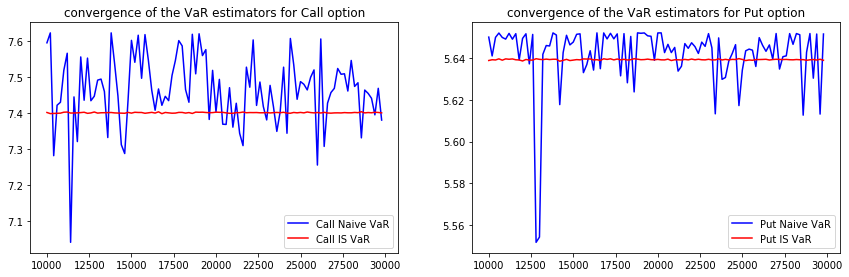

In [140]:
ISVaRC=[]
ISVaRP=[]
CISVaRC=[]
CISVaRP=[]
VarCall=[]
VarPut=[]
CVarCall=[]
CVarPut=[]
for n in range(10000,3*int(1e4),200):
    LossDGC=np.sort(Loss_DGC(S,S0,K,sigma,T,n))
    VarCall.append(LossDGC[int(np.ceil(n*alpha))])
    CVarCall.append(np.sum(LossDGC[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    LossDGP=np.sort(Loss_DGP(S,S0,K,sigma,T,n))
    VarPut.append(LossDGP[int(np.ceil(n*alpha))])
    CVarPut.append(np.sum(LossDGP[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    X=np.random.randn(n)
    Z_C=B_stdC(alpha,S0,K,sigma,T)*X+mu_C(alpha,S0,K,sigma,T)
    Z_P=B_stdP(alpha,S0,K,sigma,T)*X+mu_P(alpha,S0,K,sigma,T)
    L_C=Q_C(alpha,S0,K,sigma,T,Z_C)+a0(S0,K,sigma,T)
    L_P=Q_P(alpha,S0,K,sigma,T,Z_P)+a0(S0,K,sigma,T)
    weights_C=LR_C(alpha,S0,K,sigma,T,Z_C)
    weights_P=LR_P(alpha,S0,K,sigma,T,Z_P)
    Val_C=np.zeros((n,2))
    Val_C[:,0]=L_C
    Val_C[:,1]=weights_C
    Val_P=np.zeros((n,2))
    Val_P[:,0]=L_P
    Val_P[:,1]=weights_P
    indexes=np.argsort(Val_C[:,0])
    Val_C=Val_C[indexes,:]
    indexes=np.argsort(Val_P[:,0])
    Val_P=Val_P[indexes,:]
    k=n-1
    mea=0
    while(mea+Val_C[k,1]/n <1-alpha):
        mea+=Val_C[k,1]/n
        k-=1
    Var1=Val_C[k,0]
    ISVaRC.append(Var1)
    ES_C=np.sum(Val_C[k+1:,0]*Val_C[k+1:,1])/n + (1-alpha-np.sum(Val_C[k+1:,1])/n)*Val_C[k,0]
    ES_C=ES_C/(1-alpha)
    CISVaRC.append(ES_C)
    k=n-1
    mea=0
    while(mea+Val_P[k,1]/n <1-alpha):
        mea+=Val_P[k,1]/n
        k-=1
    Var2=Val_P[k,0]
    ISVaRP.append(Var2)
    ES_P=np.sum(Val_P[k+1:,0]*Val_P[k+1:,1])/n + (1-alpha-np.sum(Val_P[k+1:,1])/n)*Val_P[k,0]
    ES_P=ES_P/(1-alpha)
    CISVaRP.append(ES_P)
plt.subplot(1,2,1)
plt.plot(np.arange(10000,3*int(1e4),200),VarCall,label='Call Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),ISVaRC,label='Call IS VaR',color='r')
plt.legend(loc='best')
plt.title('convergence of the VaR estimators for Call option')
plt.subplot(1,2,2)
plt.plot(np.arange(10000,3*int(1e4),200),VarPut,label='Put Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),ISVaRP,label='Put IS VaR',color='r')
plt.legend(loc='best')
plt.title('convergence of the VaR estimators for Put option')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)

In [12]:
print('VaR for the call option using delta-gamma approximation and Exponential twisting is : {} . '.format(ISVaRC[-1]))
print('VaR for the put option using delta-gamma approximation and Exponential twisting is : {} . '.format(ISVaRP[-1]))

VaR for the call option using delta-gamma approximation and Exponential twisting is : 7.402069992978925 . 
VaR for the put option using delta-gamma approximation and Exponential twisting is : 5.639073821886748 . 


#### 4.3.2 CVaR calculation using importance sampling:

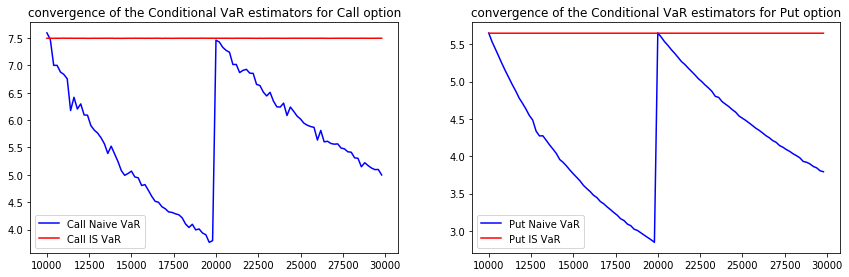

In [142]:
plt.subplot(1,2,1)
plt.plot(np.arange(10000,3*int(1e4),200),CVarCall,label='Call Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),CISVaRC,label='Call IS VaR',color='r')
plt.legend(loc='best')
plt.title('convergence of the Conditional VaR estimators for Call option')
plt.subplot(1,2,2)
plt.plot(np.arange(10000,3*int(1e4),200),CVarPut,label='Put Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),CISVaRP,label='Put IS VaR',color='r')
plt.legend(loc='best')
plt.title('convergence of the Conditional VaR estimators for Put option')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)

In [143]:
print("The Conditional VaR Value for this call option using delta-gamma approximation and Exponential twisting is : " +repr(CISVaRC[-1]))
print("The Conditional VaR Value for this put option using delta-gamma approximation and Exponential twisting is : " +repr(CISVaRP[-1]))

The Conditional VaR Value for this call option using delta-gamma approximation and Exponential twisting is : 7.497313017848263
The Conditional VaR Value for this put option using delta-gamma approximation and Exponential twisting is : 5.647576960746388


** $\textbf{Important Remarks :}$

1/ Highly precise.

2/ The Conditional VaR value using deltagamma approximation is really close to the Value of conditional Var using the naive MC method.

### 4.4 DG approximation for hedged options:

For hedged options , the only difference is that the delta term is equal to 0, it's what we call delta hedging.


#### 4.4.1 Hedged Loss function:

In [144]:
#for a hedged call:
def HedgedLoss_DGC(S,S0,K,sigma,T,N,buy=False):
    SLoss=S0*sigma*np.sqrt(T/Y)*np.random.randn(N)
    return -T*thetaC(S0,K,sigma,T)/Y-(gammaC(S0,K,sigma,T)*SLoss**2)/2

#for a hedged put:
def HedgedLoss_DGP(S,S0,K,sigma,T,N):
    SLoss=S0*sigma*np.sqrt(T/Y)*np.random.randn(N)
    return -T*thetaP(S0,K,sigma,T)/Y-(gammaP(S0,K,sigma,T)*SLoss**2)/2

In [145]:
alpha=1-1e-4
HedgedLossDGC=np.sort(HedgedLoss_DGC(S,S0,K,sigma,T,m))        
HedgedLossDGP=np.sort(HedgedLoss_DGP(S,S0,K,sigma,T,m))
HeVaRC=HedgedLossDGC[int(np.ceil(m*alpha))]
HeVaRP=HedgedLossDGP[int(np.ceil(m*alpha))]
print('VaR for the hedged call option using delta-gamma approximation is : {} . '.format(HeVaRC))
print('VaR for the hedged put option using delta-gamma approximation is : {} . '.format(HeVaRP))

VaR for the hedged call option using delta-gamma approximation is : 0.3576613467997992 . 
VaR for the hedged put option using delta-gamma approximation is : 0.357661344747117 . 


Text(0.5, 0.98, 'Convergence of VaR estimation for hedged options')

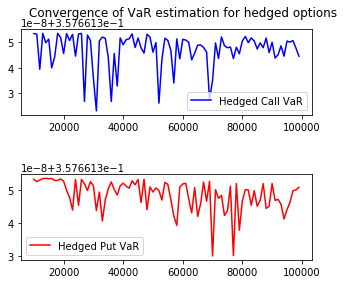

In [146]:
HedgedVarCall=[]
for i in range(10000,int(1e5),1000):
    HedgedLossDGC=np.sort(HedgedLoss_DGC(S,S0,K,sigma,T,i))
    HedgedVarCall.append(HedgedLossDGC[int(np.ceil(i*alpha))])
HedgedVarPut=[]
for i in range(10000,int(1e5),1000):
    HedgedLossDGP=np.sort(HedgedLoss_DGP(S,S0,K,sigma,T,i))
    HedgedVarPut.append(HedgedLossDGP[int(np.ceil(i*alpha))])
plt.subplot(2,1,1)
plt.plot(np.arange(10000,int(1e5),1000),HedgedVarCall,label='Hedged Call VaR',color='b')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(np.arange(10000,int(1e5),1000),HedgedVarPut,label='Hedged Put VaR',color='r')
plt.legend(loc='best')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,hspace=0.7)
plt.suptitle("Convergence of VaR estimation for hedged options")

#### 4.4.2 Conditianal Hedged VaR value using exponentional twisting :

In [147]:
HedgedVaRC=np.mean(HedgedVarCall)
HedgedVaRP=np.mean(HedgedVarPut)

def IS_CVaRC(alpha,S0,K,sigma,T,m,hedged=False):
    Z=B_stdC(alpha,S0,K,sigma,T,hedged)*np.random.randn(m)+mu_C(alpha,S0,K,sigma,T,hedged)
    Q=Q_C(alpha,S0,K,sigma,T,Z,hedged)
    if hedged:
        return HedgedVaRC+np.mean((Q-x_C(alpha,S0,K,sigma,T,hedged))*(Q>x_C(alpha,S0,K,sigma,T,hedged))*LR_C(alpha,S0,K,sigma,T,Z,hedged))/(1-alpha)
    return VaRC+np.mean((Q-x_C(alpha,S0,K,sigma,T,hedged))*(Q>x_C(alpha,S0,K,sigma,T,hedged))*LR_C(alpha,S0,K,sigma,T,Z,hedged))/(1-alpha)
def IS_CVaRP(alpha,S0,K,sigma,T,m,hedged=False):
    Z=B_stdP(alpha,S0,K,sigma,T,hedged)*np.random.randn(m)+mu_P(alpha,S0,K,sigma,T,hedged)
    Q=Q_P(alpha,S0,K,sigma,T,Z,hedged)
    if hedged:
        return HedgedVaRP+np.mean((Q-x_P(alpha,S0,K,sigma,T,hedged))*(Q>x_P(alpha,S0,K,sigma,T,hedged))*LR_P(alpha,S0,K,sigma,T,Z,hedged))/(1-alpha)
    return VaRP+np.mean((Q-x_P(alpha,S0,K,sigma,T,hedged))*(Q>x_P(alpha,S0,K,sigma,T,hedged))*LR_P(alpha,S0,K,sigma,T,Z,hedged))/(1-alpha)
print("The Conditional VaR Value for this hedged call option is : " +repr(IS_CVaRC(alpha,S0,K,sigma,T,m,True)))
print("\nThe Conditional VaR Value for this hedged put option is : " +repr(IS_CVaRP(alpha,S0,K,sigma,T,m,True)))

The Conditional VaR Value for this hedged call option is : 0.35766135172141095

The Conditional VaR Value for this hedged put option is : 0.35766135170678637


Text(0.5, 0.98, 'Convergence of CVaR estimation for hedged options')

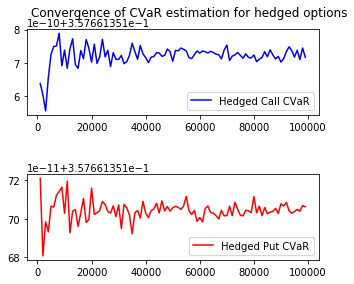

In [148]:
HedgedCvarc=[]
HedgedCvarp=[]
for i in range(1000,int(1e5),1000):
    HedgedCvarc.append(IS_CVaRC(alpha,S0,K,sigma,T,i,True))
    HedgedCvarp.append(IS_CVaRP(alpha,S0,K,sigma,T,i,True))
plt.subplot(2,1,1)
plt.plot(np.arange(1000,int(1e5),1000),HedgedCvarc,label='Hedged Call CVaR',color='b')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(np.arange(1000,int(1e5),1000),HedgedCvarp,label='Hedged Put CVaR',color='r')
plt.legend(loc='best')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,hspace=0.7)
plt.suptitle("Convergence of CVaR estimation for hedged options")

** $\textbf{Important Remarks :}$

1/ The  VaR value for hedged options is smaller than the one for non hedged options, which is good.

2/The VaR and Conditional VaR values for hedged options using DG approximation is slightly bigger than the one we calculated using naive methods, which is not contradictory with the resulting VaR values for non hedged options( they're higher too).

3/ The Conditional VaR Value for a hedged put and call option is practically the same, as the naive method predicts..

## $~~~~~~~~~~~~\textbf{5. Independant and Dependant Evolution Using DG Approximation}$
## 5.1 Independant evolution :
### 5.1.1 Defining Vector of risk factors:

*/ We consinder the case : $$ V_{t}=\sum_{i=0}^{I_{0}} (~\alpha_{i}Call(t,S_{t}^{i})+\beta_{i}Put(t,S_{t}^{i})~)$$
with:        $~~~~~~~~~~~~~~~~~~~~~I_{0}=10~~and~~\alpha_{i}=10~~and~~\beta{i}=5~~for~~all~~i.$

*/ In the independant evolution of $I_{0}$ risk factor ($I_{0}$ Stock which means a vector of risk factors) , using the delta-gamma approximation we have that :

$$\Delta S \sim \mathcal N(0,S_{0}^{2}*T*\Sigma)$$
with : $$\Sigma =
\begin{pmatrix}
\sigma_{1}^{2} & 0 & \cdots & 0 \\
0 & \sigma_{2}^{2} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & 0  \\
0 &  \cdots & 0 & \sigma_{I_{0}}^{2}
\end{pmatrix}
$$

In [157]:
#setting parameters of the covariance matrix:
m=int(1e5)
I0=10
sigma=np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7])
S0=np.array([500,400,300,200,100,50,40,30,20,10])
K=np.array([510,390,310,190,90,55,35,34,17,12])
sig=np.diag((S0*sigma)**2)
dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=m)

#### Setting delta-gamma approximation parameters for a vector of risk factors:

we have that: $$\delta_{i}=\frac{\partial V}{\partial S^{i}}~~~~ and~~~ \gamma_{i,j}=\frac{\partial^{2} V}{\partial S^{i}\partial S^{j}}$$
and since the evolution is independant we have :
$$\gamma=
\begin{pmatrix}
\frac{\partial^{2} V}{\partial S_{1}^{2}} & 0 & \cdots & 0 \\
0 & \frac{\partial^{2} V}{\partial S_{2}^{2}} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & 0  \\
0 &  \cdots & 0 & \frac{\partial^{2} V}{\partial S_{I_{0}}^{2}}\\
\end{pmatrix}
$$

The Var Value for this portfolio using naive MC is : 241.16648442097147


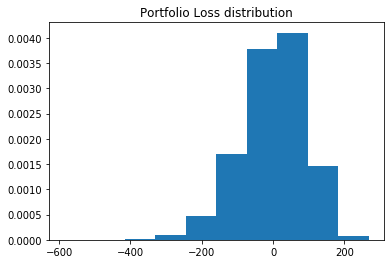

In [158]:
theta=15*np.sum(thetaC(S0,K,sigma,T))
#loss function:

def LossDGI(dS):
    return -(T/Y)*theta-np.dot(dS,5*deltaP(S0,K,sigma,T)+10*deltaC(S0,K,sigma,T))-np.dot(dS**2,5*gammaP(S0,K,sigma,T)+10*gammaC(S0,K,sigma,T))/2
dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=m)
Loss=np.sort(LossDGI(dS))
plt.hist(Loss,density=True)
plt.title('Portfolio Loss distribution')
VaR=Loss[int(np.ceil(m*alpha))]
print('The Var Value for this portfolio using naive MC is : '+repr(VaR))

Text(0.5, 1.0, 'convergence of the Naive VaR estimator')

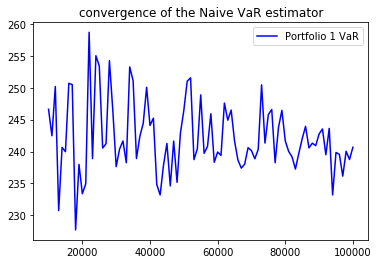

In [159]:
IndVaR=[]
for i in range(10000,int(1e5)+1,1000):
    dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=i)
    Loss=np.sort(LossDGI(dS))
    IndVaR.append(Loss[int(np.ceil(i*alpha))])
plt.plot(np.arange(10000,int(1e5)+1,1000),IndVaR,label='Portfolio 1 VaR',color='b')
plt.legend(loc='best')
plt.title('convergence of the Naive VaR estimator')

** $\textbf{Important Remark:}$

The convergence is slow due to the wide range of possible value and it requires a big number of simulations, which means we need to try other methods to find the exact value.

### 5.1.2 Robust adaptive importance sampling :

We use robust adaptive importance sampling by JOURDAIN and LELONG.
#### using a grid of possible values:

The VaR Value for this portfolio using Robust Adaptive method is :243


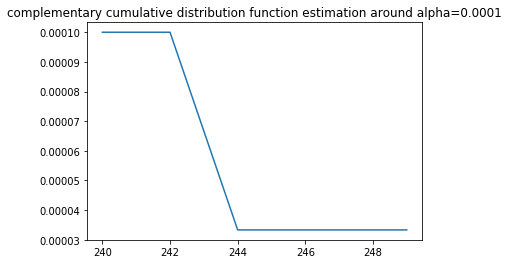

In [160]:
x=np.arange(240,250)      #the range of the possible values of VaR with 1/32 precision
k=x.shape[0]
esp=np.zeros(k)        


dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=30000)
for i in range(k):
    dS_i=dS[LossDGI(dS)>x[i]]
    B=np.linalg.inv(T*sig/Y)
    A=np.dot(dS_i,B)
    def f(y):
        return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/30000
    def jacob(y):
        return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
    def hessn(y):
        s=np.zeros((10,10))
        for j in range(np.shape(dS_i)[0]):
            s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
        return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
    theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
    lossF=LossDGI(dS+theta_minx)
    esp[i]=np.mean((lossF>x[i])*np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2))
plt.plot(x,esp)
plt.title('complementary cumulative distribution function estimation around alpha=0.0001')
VaR=x[-esp[esp<1-alpha].shape[0]]
print('The VaR Value for this portfolio using Robust Adaptive method is :'+repr(VaR))


#### using quantiles method:

The VaR Value using RIS for independant evolution is : 239.35266121503145
The Conditional VaR Value using RIS for independant evolution is : 249.4359539930565


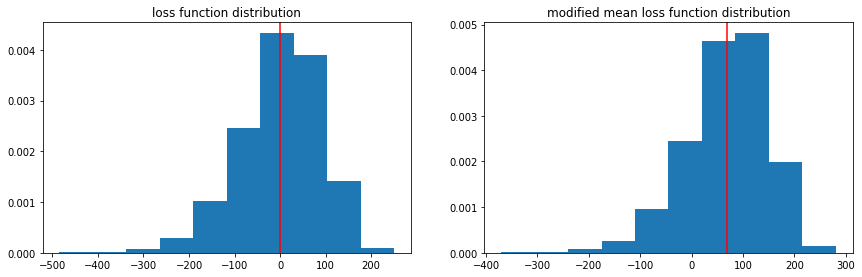

In [161]:
x=230
n=20000
dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=n)
loss=LossDGI(dS)
dS_i=dS[LossDGI(dS)>x]
B=np.linalg.inv(T*sig/Y)
A=np.dot(dS_i,B)
def f(y):
    return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/n
def jacob(y):
    return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
def hessn(y):
    s=np.zeros((10,10))
    for j in range(np.shape(dS_i)[0]):
        s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
    return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
lossF=LossDGI(dS+theta_minx)
weights=np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2)
Val=np.zeros((n,2))
Val[:,0]=lossF
Val[:,1]=weights
indexes=np.argsort(Val[:,0])
Val=Val[indexes,:]
k=n-1
mea=0
while(mea+Val[k,1]/n <1-alpha):
    mea+=Val[k,1]/n
    k-=1
VaR1=Val[k,0]
ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
ES1=ES1/(1-alpha)
plt.subplot(1,2,2)
plt.hist(Val[:,0],density=True)
plt.axvline(np.mean(Val[:,0]),color='r')
plt.title('modified mean loss function distribution')
plt.subplot(1,2,1)
plt.hist(loss,density=True)
plt.axvline(np.mean(loss),color='r')
plt.title('loss function distribution')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)

print("The VaR Value using RIS for independant evolution is : "+repr(VaR1))
print("The Conditional VaR Value using RIS for independant evolution is : "+repr(ES1))

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*/~~We~~ can~~ see~~ that~~ the~~ distribution~~is~~ amplified~~and~~ shifted~~ to~~ the~~ right.$

### 5.1.3 Exponential twisting parameters:

#### setting parameters:

In [162]:
x=VaR1
la_ind=(-5*gammaP(S0,K,sigma,T)-10*gammaC(S0,K,sigma,T))*T*((S0*sigma)**2)/(2*Y)
b_ind=(-5*deltaP(S0,K,sigma,T)-10*deltaC(S0,K,sigma,T))*np.sqrt(T*((S0*sigma)**2)/Y)
a_0=-(T/Y)*theta
print(la_ind)
def g(y):
    s=a_0-x
    for i in range(I0):
        s+=((y*b_ind[i]**2)+la_ind[i])/(1-2*y*la_ind[i])+(la_ind[i]*(y*b_ind[i])**2)/(1-2*y*la_ind[i])**2
    return s
theta_x=op.fsolve(g,0)[0]
Cov_ind=np.linalg.inv(np.eye(10)-2*theta_x*np.diag(la_ind))
mu_ind=theta_x*np.dot(Cov_ind,b_ind)
print(theta_x)

[ -8.67161649 -10.29255217 -10.60539419  -8.31733509  -4.41901963
  -3.00965428  -2.34676222  -2.63480151  -1.79240756  -1.24137928]
0.0949974272648293


### Estimators convergence:

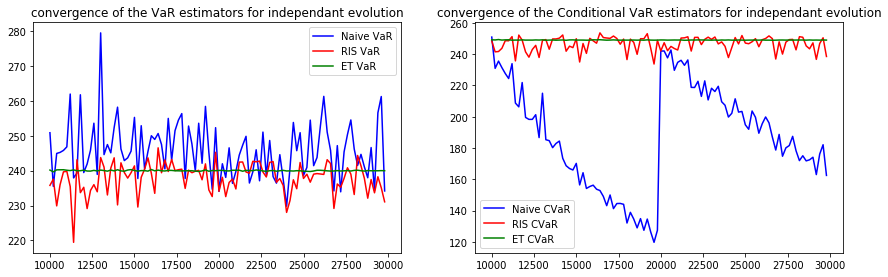

In [166]:
x=230
RISVaR=[]
VaR=[]
ETVaR=[]
CRISVaR=[]
CVaR=[]
CETVaR=[]
for n in range(10000,3*int(1e4),200):
    dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=n)
    loss=np.sort(LossDGI(dS))
    VaR.append(loss[int(np.ceil(n*alpha))])
    CVaR.append(np.sum(loss[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    dS_i=dS[LossDGI(dS)>x]
    B=np.linalg.inv(T*sig/Y)
    A=np.dot(dS_i,B)
    def f(y):
        return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/n
    def jacob(y):
        return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
    def hessn(y):
        s=np.zeros((10,10))
        for j in range(np.shape(dS_i)[0]):
            s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
        return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
    if(np.shape(dS_i)[0]==0):
        theta_minx=np.zeros(10)
    else:
        theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
    lossF=LossDGI(dS+theta_minx)
    weights=np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    RISVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CRISVaR.append(ES1)
    dS=np.random.multivariate_normal(mu_ind,Cov_ind,size=n)
    weights=np.exp((-np.dot(dS**2,np.ones(10))+np.dot((dS-mu_ind)**2,np.diag(np.linalg.inv(Cov_ind))))/2)*np.sqrt(np.linalg.det(Cov_ind))
    lossF=a_0+np.dot(dS,b_ind)+np.dot(dS**2,la_ind)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    ETVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CETVaR.append(ES1)


plt.subplot(1,2,1)
plt.plot(np.arange(10000,3*int(1e4),200),VaR,label='Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),RISVaR,label='RIS VaR',color='r')
plt.plot(np.arange(10000,3*int(1e4),200),ETVaR,label='ET VaR',color='g')
plt.title('convergence of the VaR estimators for independant evolution')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(np.arange(10000,3*int(1e4),200),CVaR,label='Naive CVaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),CRISVaR,label='RIS CVaR',color='r')
plt.plot(np.arange(10000,3*int(1e4),200),CETVaR,label='ET CVaR',color='g')
plt.title('convergence of the Conditional VaR estimators for independant evolution')
plt.legend(loc='best')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)


### boxplot for the three different estimators:

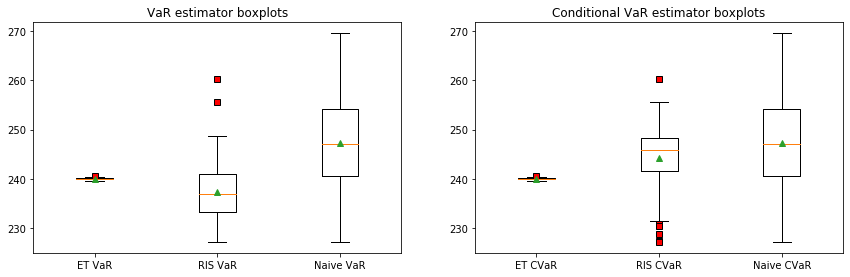

In [168]:
x=230
ETVaR=[]
CETVaR=[]
RISVaR=[]
CRISVaR=[]
VaR=[]
CVaR=[]
n=10000
for i in range(100):
    dS=np.random.multivariate_normal(np.zeros(I0),T*sig/Y,size=n)
    loss=np.sort(LossDGI(dS))
    VaR.append(loss[int(np.ceil(n*alpha))])
    CVaR.append(np.sum(loss[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    dS_i=dS[LossDGI(dS)>x]
    B=np.linalg.inv(T*sig/Y)
    A=np.dot(dS_i,B)
    def f(y):
        return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/n
    def jacob(y):
        return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
    def hessn(y):
        s=np.zeros((10,10))
        for j in range(np.shape(dS_i)[0]):
            s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
        return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
    if(np.shape(dS_i)[0]==0):
        theta_minx=np.zeros(10)
    else:
        theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
    lossF_RIS=LossDGI(dS+theta_minx)
    weights_RIS=np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2)
    Val1=np.zeros((n,2))
    Val1[:,0]=lossF_RIS
    Val1[:,1]=weights_RIS
    indexes=np.argsort(Val1[:,0])
    Val1=Val1[indexes,:]
    k=n-1
    mea=0
    while(mea+Val1[k,1]/n <1-alpha):
        mea+=Val1[k,1]/n
        k-=1
    Var1=Val1[k,0]
    RISVaR.append(Var1)
    ES1=np.sum(Val1[k+1:,0]*Val1[k+1:,1])/n + (1-alpha-np.sum(Val1[k+1:,1])/n)*Val1[k,0]
    ES1=ES1/(1-alpha)
    CRISVaR.append(ES1)
    dS=np.random.multivariate_normal(mu_ind,Cov_ind,size=n)
    weights_ET=np.exp((-np.dot(dS**2,np.ones(10))+np.dot((dS-mu_ind)**2,np.diag(np.linalg.inv(Cov_ind))))/2)*np.sqrt(np.linalg.det(Cov_ind))
    lossF_ET=a_0+np.dot(dS,b_ind)+np.dot(dS**2,la_ind)
    Val2=np.zeros((n,2))
    Val2[:,0]=lossF_ET
    Val2[:,1]=weights_ET
    indexes=np.argsort(Val2[:,0])
    Val2=Val2[indexes,:]
    k=n-1
    mea=0
    while(mea+Val2[k,1]/n <1-alpha):
        mea+=Val2[k,1]/n
        k-=1
    Var1=Val2[k,0]
    ETVaR.append(Var1)
    ES1=np.sum(Val2[k+1:,0]*Val2[k+1:,1])/n + (1-alpha-np.sum(Val2[k+1:,1])/n)*Val2[k,0]
    ES1=ES1/(1-alpha)
    CETVaR.append(ES1)
red_square = dict(markerfacecolor='r', marker='s')
plt.subplot(1,2,1)
plt.boxplot([ETVaR,RISVaR,VaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('ET VaR','RIS VaR','Naive VaR'))
plt.title('VaR estimator boxplots')
plt.subplot(1,2,2)
plt.boxplot([ETVaR,CRISVaR,CVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('ET CVaR','RIS CVaR','Naive CVaR'))
plt.title('Conditional VaR estimator boxplots')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)

### 5.2 dependant evolution:

*/ In the dependant evolution of $I_{0}$ risk factor ($I_{0}$ Stock which means a vector of risk factors) , using the delta-gamma approximation we have that :

$$\Delta S \sim \mathcal N(0,T*\Sigma')$$
with : $$\Sigma' =
\begin{pmatrix}
\sigma_{1}^{2}(S_{1}^{0})^{2} & \rho\sigma_{1}^{2}\sigma_{2}^{2}S_{1}^{0}S_{2}^{0} & \cdots & \rho\sigma_{1}^{2}\sigma_{I_{0}}^{2}S_{1}^{0}S_{I_{0}}^{0} \\
\rho\sigma_{2}^{2}\sigma_{1}^{2}S_{1}^{0}S_{2}^{0}&\sigma_{2}^{2}(S_{2}^{0})^{2} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & \rho S_{I_{0}-1}^{0}S_{I_{0}}^{0}  \\
\rho\sigma_{2}^{2}\sigma_{1}^{2}S_{1}^{0}S_{I_{0}}^{0} &  \cdots & \rho\sigma_{I_{0}-1}^{2}\sigma_{I_{0}}^{2}S_{I_{0}}^{0}S_{I_{0}-1}^{0} & \sigma_{I_{0}}^{2}(S_{I_{0}}^{0})^{2}
\end{pmatrix}
$$

In [44]:
rho=0.1 #dependancy of 10%
sig_dep=rho*(np.tensordot(S0*sigma,S0*sigma,axes=0)+((-1+1/rho)*np.diag((S0*sigma)**2)))

Text(0.5, 1.0, 'distribution of 10% dependant loss function ')

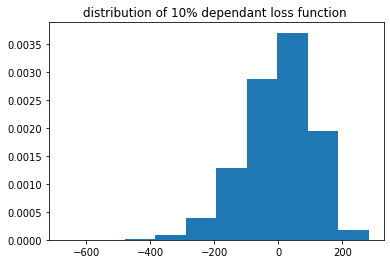

In [103]:
dS_dep=np.random.multivariate_normal(np.zeros(I0),T*sig_dep/Y,size=m)
Cgamma=np.diag(gammaC(S0,K,sigma,T))
Pgamma=np.diag(gammaP(S0,K,sigma,T))
#multiply function:
def multipl(A,B):
    s=[]
    for i in range(np.shape(A)[0]):
        s.append(np.dot(A[i,:],B[i,:]))
    return np.array(s)
#loss function:
def LossDGD(dS):
    return -(T/Y)*theta-np.dot(dS,5*deltaP(S0,K,sigma,T)+10*deltaC(S0,K,sigma,T))-multipl(dS,np.dot(dS,5*Pgamma+10*Cgamma))/2

Loss=np.sort(LossDGD(dS_dep))
plt.hist(Loss,density=True)
plt.title('distribution of 10% dependant loss function ')


The distribution is heavy tailed, which means the VaR estimation is inprecise, we need then to use the RIS method to get 

In [104]:
VaR=Loss[int(np.ceil(m*alpha))]
print("The VaR value using naive MC method for dependant evolution is : "+repr(VaR))

The VaR value using naive MC method for dependant evolution is : 265.7532529129189


### ET  estimator parameter:

In [105]:
x=VaR
L=np.linalg.cholesky(T*sig_dep/Y)
la_dep,U=np.linalg.eig(np.dot(np.transpose(L),np.dot((-5*Pgamma-10*Cgamma)/2,L)))
b_dep=np.dot(-5*deltaP(S0,K,sigma,T)-10*deltaC(S0,K,sigma,T),np.dot(L,U))
def g(y):
    s=a_0-x
    for i in range(I0):
        s+=((y*b_dep[i]**2)+la_dep[i])/(1-2*y*la_dep[i])+(la_dep[i]*(y*b_dep[i])**2)/(1-2*y*la_dep[i])**2
    return s
theta_x=op.fsolve(g,0)[0]
Cov_dep=np.linalg.inv(np.eye(10)-2*theta_x*np.diag(la_dep))
mu_dep=theta_x*np.dot(Cov_dep,b_dep)
print(theta_x)

0.10188282069953124


#### RIS Method,ET Method and Naive method for dependant evolution:

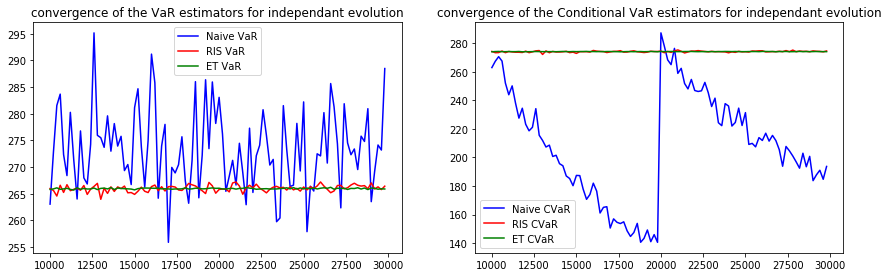

In [111]:
x=230

ETVaR=[]
RISVaR=[]
VaR=[]
CRISVaR=[]
CVaR=[]
CETVaR=[]
for n in range(10000,3*int(1e4),200):
    dS=np.random.multivariate_normal(np.zeros(I0),T*sig_dep/Y,size=n)
    loss=np.sort(LossDGD(dS))
    VaR.append(loss[int(np.ceil(n*alpha))])
    CVaR.append(np.sum(loss[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    dS_i=dS[LossDGD(dS)>x]
    B=np.linalg.inv(T*sig_dep/Y)
    A=np.dot(dS_i,B)
    def f(y):
        return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/n
    def jacob(y):
        return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
    def hessn(y):
        s=np.zeros((10,10))
        for j in range(np.shape(dS_i)[0]):
            s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
        return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
    if(np.shape(dS_i)[0]==0):
        theta_minx=np.zeros(10)
    else:
        theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
    lossF=LossDGD(dS+theta_minx)
    weights=np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    RISVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CRISVaR.append(ES1)
    dS=np.random.multivariate_normal(mu_dep,Cov_dep,size=n)
    weights=np.exp((-np.dot(dS**2,np.ones(10))+np.dot((dS-mu_dep)**2,np.diag(np.linalg.inv(Cov_dep))))/2)*np.sqrt(np.linalg.det(Cov_dep))
    lossF=a_0+np.dot(dS,b_dep)+np.dot(dS**2,la_dep)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    ETVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CETVaR.append(ES1)


plt.subplot(1,2,1)
plt.plot(np.arange(10000,3*int(1e4),200),VaR,label='Naive VaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),RISVaR,label='RIS VaR',color='r')
plt.plot(np.arange(10000,3*int(1e4),200),ETVaR,label='ET VaR',color='g')
plt.title('convergence of the VaR estimators for independant evolution')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(np.arange(10000,3*int(1e4),200),CVaR,label='Naive CVaR',color='b')
plt.plot(np.arange(10000,3*int(1e4),200),CRISVaR,label='RIS CVaR',color='r')
plt.plot(np.arange(10000,3*int(1e4),200),CETVaR,label='ET CVaR',color='g')
plt.title('convergence of the Conditional VaR estimators for independant evolution')
plt.legend(loc='best')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)


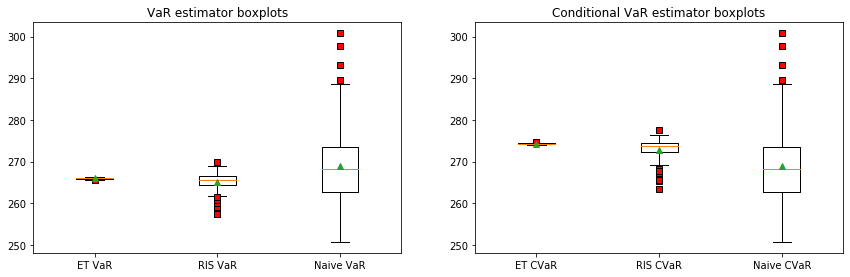

In [102]:
x=240
n=10000
ETVaR=[]
RISVaR=[]
VaR=[]
CRISVaR=[]
CVaR=[]
CETVaR=[]
for i in range(100):
    dS=np.random.multivariate_normal(np.zeros(I0),T*sig_dep/Y,size=n)
    loss=np.sort(LossDGD(dS))
    VaR.append(loss[int(np.ceil(n*alpha))])
    CVaR.append(np.sum(loss[int(np.ceil(n*alpha)):])/(n*(1-alpha)))
    dS_i=dS[LossDGD(dS)>x]
    B=np.linalg.inv(T*sig_dep/Y)
    A=np.dot(dS_i,B)
    def f(y):
        return np.sum(np.exp(-np.dot(A,y)+(np.dot(y,np.dot(B,y)))/2))/n
    def jacob(y):
        return np.dot(B,y)-np.dot(np.exp(-np.dot(A,y)),A)/np.sum(np.exp(-np.dot(A,y)))
    def hessn(y):
        s=np.zeros((10,10))
        for j in range(np.shape(dS_i)[0]):
            s+=np.exp(-np.dot(dS_i[j,:],np.dot(B,y)))*np.tensordot(np.dot(B,dS_i[j,:]),np.dot(B,dS_i[j,:]),axes=0) 
        return B+s/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))-np.tensordot(np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),np.dot(np.exp(-np.dot(dS_i,np.dot(B,y))),A),axes=0)/np.sum(np.exp(-np.dot(dS_i,np.dot(B,y))))**2
    if(np.shape(dS_i)[0]==0):
        theta_minx=np.zeros(10)
    else:
        theta_minx=op.minimize(f,np.zeros(10),method='Newton-CG',jac=jacob,hess=hessn).x
    lossF=LossDGD(dS+theta_minx)
    weights=np.exp(-np.dot(dS,np.dot(B,theta_minx))-(np.dot(theta_minx,np.dot(B,theta_minx)))/2)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    RISVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CRISVaR.append(ES1)
    dS=np.random.multivariate_normal(mu_dep,Cov_dep,size=n)
    weights=np.exp((-np.dot(dS**2,np.ones(10))+np.dot((dS-mu_dep)**2,np.diag(np.linalg.inv(Cov_dep))))/2)*np.sqrt(np.linalg.det(Cov_dep))
    lossF=a_0+np.dot(dS,b_dep)+np.dot(dS**2,la_dep)
    Val=np.zeros((n,2))
    Val[:,0]=lossF
    Val[:,1]=weights
    indexes=np.argsort(Val[:,0])
    Val=Val[indexes,:]
    k=n-1
    mea=0
    while(mea+Val[k,1]/n <1-alpha):
        mea+=Val[k,1]/n
        k-=1
    Var1=Val[k,0]
    ETVaR.append(Var1)
    ES1=np.sum(Val[k+1:,0]*Val[k+1:,1])/n + (1-alpha-np.sum(Val[k+1:,1])/n)*Val[k,0]
    ES1=ES1/(1-alpha)
    CETVaR.append(ES1)
    
red_square = dict(markerfacecolor='r', marker='s')
plt.subplot(1,2,1)
plt.boxplot([ETVaR,RISVaR,VaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('ET VaR','RIS VaR','Naive VaR'))
plt.title('VaR estimator boxplots')
plt.subplot(1,2,2)
plt.boxplot([CETVaR,CRISVaR,CVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('ET CVaR','RIS CVaR','Naive CVaR'))
plt.title('Conditional VaR estimator boxplots')
plt.subplots_adjust(bottom=0.1, right=2, top=0.9,hspace=0.7)